## Simulated method of moment estimation of an AR1

In [1]:
import numpy as np
import scipy as sp 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [4]:
## A simple estimation 

p_fake = 0.2
data_mean,data_var = bernoulli.stats(p_fake, loc=0, moments='mv')
data_moms = np.array([data_mean,data_var])

def simulate(p,
           n_sim):
    np.random.seed(22222)
    draws = bernoulli.rvs(p = p,
                          size = n_sim)
    sim_mean = np.mean(draws)
    sim_var = np.var(draws)
    sim_moms = np.array([sim_mean,sim_var])
    return sim_moms

def loss(p):
    #np.random.seed(1224)
    sim_mom = simulate(p,n_sim = 1000)
    distance = sim_mom - data_moms
    loss = np.linalg.norm(distance)
    #print('loss ='+str(loss))
    return loss

p_est = minimize(loss,
                 method='Nelder-Mead',
                 x0 = 0.1)['x']
print('true parameters: ', str(p_fake))
print('estimated parameter: ',str(p_est))

true parameters:  0.2
estimated parameter:  [0.2025]


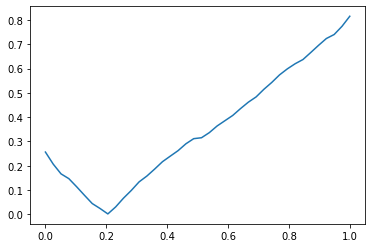

In [5]:
# plot the loss function for different p
ps = np.linspace(0,1,40)
losses = np.array([loss(p) for p in ps])
plt.plot(ps,losses)

## For An AR1 process

In [6]:
## some process parameters 
rho = 0.98
sigma = 0.4
process_para = {'rho':rho,
                'sigma':sigma}

In [7]:
class SMMAR:
    def __init__(self,
                 process_para,
                 T = 1000,
                 T_burn = 30):
        self.process_para = process_para
        self.T = T
        self.T_burn = T_burn
        self.rho = self.process_para['rho']
        self.sigma = self.process_para['sigma']
        self.moments = ['YVar','resdVar','YATV']
        
    def Simulate(self,
                 seed = True):
        
        T = self.T
        T_burn = self.T_burn
        rho = self.rho
        self.sigma = self.sigma
        
        xxx = np.zeros(T+1)
        if seed == True:
            np.random.seed(12234)
        elif seed == False:
            None
        shocks = np.random.randn(T+1)*sigma
        xxx[0] = 0 
        for i in range(T):
            xxx[i+1] = rho*xxx[i] + shocks[i+1]
        self.Simulated = xxx[T_burn:]
        
        ## simulated moments  
        resds = np.mean(self.Simulated[1:]-rho*self.Simulated[:-1])
        resd_sim = np.mean(resds)
        resdVar_sim = np.mean(resds**2)
        Yresd_sim = np.mean(self.Simulated[:-1]*resds)
        YVar_sim = np.var(self.Simulated)
        YATV_sim = np.cov(np.stack((self.Simulated[1:],self.Simulated[:-1]),axis=0))[0,1] 
        
        self.SimulatedMoments= {"resd":resd_sim,
                                "Yresd":Yresd_sim,
                                "YVar":YVar_sim,
                                "resdVar":resdVar_sim,
                                "YATV":YATV_sim
                               }
        
    def Compute(self):
        rho = self.rho
        sigma = self.sigma
        
        ## model 
        
        resd = 0 
        Yresd = 0 
        resdVar = sigma**2
        YVar = sigma**2/(1-rho**2)
        YATV = rho*YVar
        
        self.ComputeMoments= {"resd":resd,
                              "Yresd":Yresd,
                              "YVar":YVar,
                              "resdVar":resdVar,
                              "YATV":YATV
                             }
        
    def GetDataMoments(self,
                       data_moms_dct):
        self.data_moms_dct = data_moms_dct
    
    def SMMObj(self,
               paras):
        ## data moments
        data_moms_dct = self.data_moms_dct
        
        ## parameters 
        self.rho = paras[0]
        self.sigma = paras[1]
        self.Simulate()
        
        sim_moms_dct = self.SimulatedMoments
        sim_moms = np.array([sim_moms_dct[key] for key in self.moments])
        data_moms = np.array([data_moms_dct[key] for key in self.moments])
        assert len(sim_moms) == len(data_moms), "not equal lenghth"
        distance = sim_moms - data_moms
        obj_func = np.linalg.norm(distance)
        return obj_func
    
    def GMMObj(self,
               paras):
        ## data moments
        data_moms_dct = self.data_moms_dct
        
        ## parameters 
        self.rho = paras[0]
        self.sigma = paras[1]
        self.Compute()
        
        com_moms_dct = self.ComputeMoments
        com_moms = np.array([com_moms_dct[key] for key in self.moments])
        data_moms = np.array([data_moms_dct[key] for key in self.moments])
        assert len(com_moms) == len(data_moms), "not equal lenghth"
        distance = com_moms - data_moms
        obj_func = np.linalg.norm(distance)
        return obj_func
    
    def SMMObjwm1st(self,
                    paras):
        
        # estimate first step 
        self.ParaEstimateSMM()
        self.WM1st()
        
        ## data moments
        data_moms_dct = self.data_moms_dct
        
        ## 1-step weighting matrix 
        wm1st = self.wm1st
        
        ## parameters 
        self.rho = paras[0]
        self.sigma = paras[1]
        self.Simulate(seed = True)
        
        sim_moms_dct = self.SimulatedMoments
        sim_moms = np.array([sim_moms_dct[key] for key in self.moments])
        data_moms = np.array([data_moms_dct[key] for key in self.moments])
        assert len(sim_moms) == len(data_moms), "not equal lenghth"
        distance = sim_moms - data_moms
        tmp = np.multiply(np.multiply(distance.T,wm1st),distance)  ## need to make sure it is right. 
        obj_func = np.sum(tmp)
        return obj_func
    
    def SMMObjwmboot(self,
                    paras):
        
        # estimate bootstrapping sample 
        self.ParaEstimateSMM()
        self.WMboot(n_boot = 100)
        wm_boot = self.wm_boot
        
        ## data moments
        data_moms_dct = self.data_moms_dct
        
        ## parameters 
        self.rho = paras[0]
        self.sigma = paras[1]
        self.Simulate()
        
        # loss func
        sim_moms_dct = self.SimulatedMoments
        sim_moms = np.array([sim_moms_dct[key] for key in self.moments])
        data_moms = np.array([data_moms_dct[key] for key in self.moments])
        assert len(sim_moms) == len(data_moms), "not equal lenghth"
        distance = sim_moms - data_moms
        obj_func = np.sum(distance*wm_boot*distance.T)
        return obj_func
        
    def ParaEstimateSMM(self,
                        wb = 'identity', ## the type of weighting matrix to use
                        para_guess = np.array([0.8,0.1]),
                        method='CG',
                        bounds = None,
                        options = None):
        if wb =='identity':
            self.para_estSMM = minimize(self.SMMObj,
                                         x0 = para_guess,
                                         method = method,
                                         bounds = bounds,
                                         options = options)
        if wb == '2-step':
            self.para_estSMM = minimize(self.SMMObjwm1st,
                                         x0 = para_guess,
                                         method = method,
                                         bounds = bounds,
                                         options = options)
        if wb == 'bootstrap':
            self.para_estSMM = minimize(self.SMMObjwmboot,
                                         x0 = para_guess,
                                         method = method,
                                         bounds = bounds,
                                         options = options)
        return self.para_estSMM
    
    def ParaEstimateGMM(self,
                        wb = 'identity', ## the type of weighting matrix to use
                        para_guess = np.array([0.8,0.1]),
                        method='CG',
                        bounds = None,
                        options = None):
        if wb =='identity':
            self.para_estGMM = minimize(self.GMMObj,
                                         x0 = para_guess,
                                         method = method,
                                         bounds = bounds,
                                         options = options)
        if wb == '2-step':
            self.para_estGMM = minimize(self.GMMObjwm1st,
                                         x0 = para_guess,
                                         method = method,
                                         bounds = bounds,
                                         options = options)
        if wb == 'bootstrap':
            self.para_estGMM = minimize(self.GMMObjwmboot,
                                         x0 = para_guess,
                                         method = method,
                                         bounds = bounds,
                                         options = options)
        return self.para_estGMM
    
    def WM1st(self):
        """
        - get the 1-st step variance and covariance matrix
        """
        self.rho = self.para_estSMM['x'][0]
        self.sigma = self.para_estSMM['x'][1]
        self.Simulate()
        sim_moms_dct = self.SimulatedMoments
        data_moms_dct = self.data_moms_dct
        sim_moms = np.array([sim_moms_dct[key] for key in self.moments])
        data_moms = np.array([data_moms_dct[key] for key in self.moments])
        distance = sim_moms - data_moms
        distance_diag = np.diag(distance*distance.T)
        self.wm1st = np.linalg.inv(distance_diag)
        return self.wm1st
    
    def WMboot(self,
               n_boot = 3):
        # data moments 
        data_moms_dct = self.data_moms_dct
        
        # parameters 
        self.rho = self.para_estSMM['x'][0]
        self.sigma = self.para_estSMM['x'][1]
        

        distance_boot = []
        
        for i in range(n_boot): 
            self.Simulate(seed = False)
            sim_moms_dct = self.SimulatedMoments
            sim_moms = np.array([sim_moms_dct[key] for key in self.moments])
            data_moms = np.array([data_moms_dct[key] for key in self.moments])
            distance = sim_moms - data_moms
            distance_boot.append(np.array(distance))
        #print(np.array(distance_boot).shape)
        vcv_boot_ary = np.array(distance_boot, dtype=np.float64)
        self.vcv_boot = np.cov(vcv_boot_ary.T)
        #print(self.vcv_boot)
        self.wm_boot = np.linalg.inv(self.vcv_boot)

In [8]:
## prepare instances 

smm_fake = SMMAR(process_para)

smm_est = SMMAR(process_para)

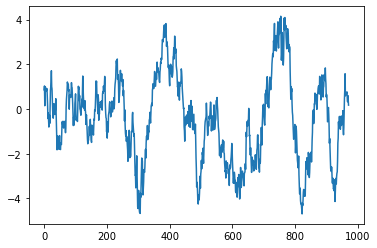

In [9]:
## simulation 
smm_fake.Simulate()
plt.plot(smm_fake.Simulated.copy())

In [10]:
## Try computing some losses
smm_est.GetDataMoments(smm_fake.SimulatedMoments.copy())
#smm_est.GMMObj(np.array([0.89,0.2]))

In [17]:
## GMM Estimation

smm_est.ParaEstimateGMM(method ='BFGS',
                        para_guess = np.array([0.9,0.1]),
                        options = {'disp':True})

         Current function value: 0.047587
         Iterations: 49
         Function evaluations: 402
         Gradient evaluations: 130


      fun: 0.047587387199270775
 hess_inv: array([[ 0.00034088, -0.00867027],
       [-0.00867027,  0.22053415]])
      jac: array([10.46887404,  0.41120324])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 402
      nit: 49
     njev: 130
   status: 2
  success: False
        x: array([0.99728602, 0.13869026])

In [20]:
## SMM Estimation 
print('True parameters: '+str([rho,sigma]))
smm_est.ParaEstimateSMM(method='Nelder-Mead',
                        options = {'disp':True})

True parameters: [0.98, 0.4]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 64
         Function evaluations: 133


 final_simplex: (array([[0.98      , 0.08625   ],
       [0.98      , 0.08621094],
       [0.98      , 0.08631836]]), array([0., 0., 0.]))
           fun: 0.0
       message: 'Optimization terminated successfully.'
          nfev: 133
           nit: 64
        status: 0
       success: True
             x: array([0.98   , 0.08625])

In [21]:
## Estimation 
smm_est.ParaEstimateSMM(method='Nelder-Mead',
                        wb = '2-step',
                        options = {'disp':True})

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/s

Optimization terminated successfully.
         Current function value: 0.016657
         Iterations: 39
         Function evaluations: 89


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

 final_simplex: (array([[0.97692683, 0.09095512],
       [0.97692617, 0.09095502],
       [0.97692589, 0.09095555]]), array([0.01665703, 0.01666368, 0.01666659]))
           fun: 0.01665703329484777
       message: 'Optimization terminated successfully.'
          nfev: 89
           nit: 39
        status: 0
       success: True
             x: array([0.97692683, 0.09095512])

In [22]:
#smm_est.WMboot()
#smm_est.SMMObjwmboot(np.array([0.7,0.2]))

In [22]:
#np.seterr(all='warn')

smm_est.ParaEstimateSMM(method='Nelder-Mead',
                        wb = 'bootstrap',
                        options = {'disp':True})

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/s

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 66
         Function evaluations: 137


/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/tao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


 final_simplex: (array([[0.98      , 0.094375  ],
       [0.98      , 0.09432129],
       [0.98      , 0.09435181]]), array([-5.8631621e-24, -5.8631621e-24, -5.8631621e-24]))
           fun: -5.8631620959329186e-24
       message: 'Optimization terminated successfully.'
          nfev: 137
           nit: 66
        status: 0
       success: True
             x: array([0.98    , 0.094375])